# **<center>Modelo de segmentación de la cartera de clientes sujetos a corte del suministro eléctrico</center>**

### <center>lnieto@ensa.com.pa</center>


---

## Introducción

Dentro de la cartera de clientes de ENSA, hay un porcentaje de clientes que están sujetos al corte del suministro eléctrico. Esto quiere decir que tienen una deuda vencida de 60 o más días y un saldo vencido igual o mayor a 20 dólares. 

Para los meses de septiembre y octubre de 2022 esta cifra fue de 36 mil y 38 mil clientes. El problema es que la empresa tiene una capacidad operativa limitada de aproximadamente 10 mil cortes. 

Para dar una solución a esta problemática realizamos una segmentación de clientes y así adoptar distintas estrategias de cobranzas para cada grupo. La segmentación de clientes se basa en agrupar a los clientes que tienen características iguales en un mismo grupo. Por último, las recomendaciones o estrategias de cobro se asignan de acuerdo con las características de cada clúster.


## **Librerías**
Las librerías utilizadas en este documento son:

In [ ]:
# Tratmiento de datos
# =============================================================================
import numpy as np
import pandas as pd

# Gráficos
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
!pip install sweetviz --quiet
import sweetviz as sv

# Preprocesado
# =============================================================================
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Modelado
# =============================================================================
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans

# Métricas
# =============================================================================
from sklearn.metrics import mean_absolute_error

# Persistencia de las técnicas 
# =============================================================================
from joblib import dump, load

# Permisos Google Drive
# =============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Permisos Google Sheet
# =============================================================================
!pip install kora --quiet
import gspread
from google.colab import auth
from google.auth import default
from kora.xattr import get_id
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Configuración warnings
# ==============================================================================
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Fuentes de datos**

Para realizar la segmentación de clientes sujetos a corte se utilizan de tres fuentes de datos que listamos a continuación:

- Extractor de morosidad al cierre del mes anterior.
- Pagos de los últimos 36 meses.
- Cortes y reconexiones de los últimos 36 meses.


In [ ]:
# Extractor de morosidad al cierre del mes anterior. 
# =============================================================================
path_extractor='/content/drive/MyDrive/ENSA/Modelo de corte inteligente/Auxiliar al 10_11_22 morosidad.xlsx'
morosidad=pd.read_excel(path_extractor)
morosidad.head()

,Número interlocutor comercial,Nombre interlocutor comercial,Número cuenta contrato,Nombre de la cuenta contrato,Cód. categoría cuenta contrato,Categoría cuenta contrato,Clase interlocutor comercial,Clasificación CSS Interlocutor comercial,Característica determinación de cuenta,Cuenta Colectiva,...,Estrategia cobranza cuenta contrato,Tiene Bloqueo de Cuenta Contrato,Tiene Bloqueo de Documento,Cód. motivo garantía suministro instalación,Motivo garantía suministro instalación,Vía de Pago,Control Exp Factura,Fecha desde cheque devuelto,Fecha hasta cheque devuelto,Buen Pagador
0,10458961,ARISTIDES SANTOS POLANCO POLANCO,812245,ARISTIDES SANTOS POLANCO,1,Residencial,Normales,NaN,Residenciales/ Empleados ENSA,NaN,...,Residenciales,,,,NaN,,Entrega a domicilio,NaN,NaN,
1,10206284,ARMANDO MAYORGA,178425,ARMANDO MAYORGA,1,Residencial,Normales,NaN,Residenciales/ Empleados ENSA,NaN,...,Residenciales,,,,NaN,,Enviar correo electrónico,NaN,NaN,X
2,10054874,ARMANDO OSORIO RIOS RIOS,249786,ARMANDO OSORIO RIOS,1,Residencial,Normales,NaN,Residenciales/ Empleados ENSA,NaN,...,Residenciales,,,,NaN,,Enviar correo electrónico,NaN,NaN,
3,10458688,ARMANDO RAMIREZ GARCES GARCES,594944,ARMANDO RAMIREZ GARCES,1,Residencial,Normales,NaN,Residenciales/ Empleados ENSA,NaN,...,Residenciales,,,,NaN,,Enviar correo electrónico,NaN,NaN,X
4,10063309,AURELIO ANDRION,362394,AURELIO ANDRION,1,Residencial,Normales,NaN,Residenciales/ Empleados ENSA,NaN,...,Residenciales,,,,NaN,,Entrega a domicilio,NaN,NaN,X


In [ ]:
# Pagos de los últimos 36 meses.
# =============================================================================
path_pagos='/content/drive/MyDrive/ENSA/Modelo de corte inteligente/pagos.csv'
pagos=pd.read_csv(path_pagos, low_memory=False)
pagos.head()

,Codigo CC,Fecha contabilizacion,Monto recaudado
0,1123,2022-07-28,10.0
1,1983,2022-06-15,20.0
2,3106,2022-06-27,20.0
3,3238,2022-06-03,500.0
4,3492,2022-07-30,42.37


In [ ]:
# Cortes y reconexiones de los últimos 36 meses.
# =============================================================================
path_cortes_recos='/content/drive/MyDrive/ENSA/Modelo de corte inteligente/Cortes y Recos.csv'
cortes_recos = pd.read_csv(path_cortes_recos)
cortes_recos.head()

,Número de aviso,Nº cta.contrato,Grupo de Códigos: Codificación,Codificación - Descripción,Fecha de creación del aviso,Fecha de ejecución,Aviso-Resultado:Nombre Código Resultado
0,303591324,850359,CORTE,SOLICITUD DE CORTE POR DEUDA,2019-10-31,2019-11-07,CORTE EFECTIVO AL MEDIDOR CON SELLO
1,303603076,850359,RECONEXI,SOLICITUD DE RECONEXION POR DEUDA,2019-11-07,2019-11-09,DEBE ADECUAR INSTALACIONES
2,303603076,850359,RECONEXI,SOLICITUD DE RECONEXION POR DEUDA,2019-11-07,2019-11-09,RECO/ INSTALACION
3,303452256,850359,CORTE,SOLICITUD DE CORTE POR DEUDA,2019-09-03,2019-09-05,CORTE EFECTIVO AL MEDIDOR CON SELLO
4,303462606,850359,RECONEXI,SOLICITUD DE RECONEXION POR DEUDA,2019-09-05,2019-09-06,RECO EFECTIVA AL MED CON SELLO


## **Pre-Procesamiento**

En esta esta fase realizamos todas las transformaciones necesarias a las distintas fuentes de datos, para luego unir todos los data frames en uno solo, al cual le vamos a aplicar las distintas técnicas o algoritmos de machine learning.

In [ ]:
# Se seleccionan a los clientes que estan conextados.
# =============================================================================
morosidad_conectados = morosidad[morosidad['Estado de la instalación']!='DESCONECTADO']
morosidad_conectados.reset_index(inplace=True)
morosidad_conectados.head()

,index,Número interlocutor comercial,Nombre interlocutor comercial,Número cuenta contrato,Nombre de la cuenta contrato,Cód. categoría cuenta contrato,Categoría cuenta contrato,Clase interlocutor comercial,Clasificación CSS Interlocutor comercial,Característica determinación de cuenta,...,Estrategia cobranza cuenta contrato,Tiene Bloqueo de Cuenta Contrato,Tiene Bloqueo de Documento,Cód. motivo garantía suministro instalación,Motivo garantía suministro instalación,Vía de Pago,Control Exp Factura,Fecha desde cheque devuelto,Fecha hasta cheque devuelto,Buen Pagador
0,0,10458961,ARISTIDES SANTOS POLANCO POLANCO,812245,ARISTIDES SANTOS POLANCO,1,Residencial,Normales,NaN,Residenciales/ Empleados ENSA,...,Residenciales,,,,NaN,,Entrega a domicilio,NaN,NaN,
1,1,10206284,ARMANDO MAYORGA,178425,ARMANDO MAYORGA,1,Residencial,Normales,NaN,Residenciales/ Empleados ENSA,...,Residenciales,,,,NaN,,Enviar correo electrónico,NaN,NaN,X
2,2,10054874,ARMANDO OSORIO RIOS RIOS,249786,ARMANDO OSORIO RIOS,1,Residencial,Normales,NaN,Residenciales/ Empleados ENSA,...,Residenciales,,,,NaN,,Enviar correo electrónico,NaN,NaN,
3,3,10458688,ARMANDO RAMIREZ GARCES GARCES,594944,ARMANDO RAMIREZ GARCES,1,Residencial,Normales,NaN,Residenciales/ Empleados ENSA,...,Residenciales,,,,NaN,,Enviar correo electrónico,NaN,NaN,X
4,4,10063309,AURELIO ANDRION,362394,AURELIO ANDRION,1,Residencial,Normales,NaN,Residenciales/ Empleados ENSA,...,Residenciales,,,,NaN,,Entrega a domicilio,NaN,NaN,X


In [ ]:
# Se seleccionan las columnas con las edad de mora, saldos y el número de cuenta.
# =============================================================================
datos_morosidad = morosidad_conectados[
    ['Número cuenta contrato', 'Deuda corriente', 'Deuda 30 días',
    'Deuda 60 días', 'Deuda 90 días', 'Deuda 120 días', 'Deuda 150 días',
    'Deuda 180 días', 'Deuda 210 días', 'Deuda 365 días',
    'Deuda > 365 días', 'Monto último pago', 'Fecha último pago']
]

# Se reemplazar los missing values (sin saldo) por cero.
# =============================================================================
datos_morosidad.fillna(0, inplace=True)

# Se cambian los nombres de las columnas (variables) a mayúscula cerrada.
# =============================================================================
datos_morosidad.columns = datos_morosidad.columns.str.upper()

# Parseo de fechas
# =============================================================================
datos_morosidad['FECHA ÚLTIMO PAGO']=pd.to_datetime(
    datos_morosidad['FECHA ÚLTIMO PAGO'], format='%Y.%m.%d'
)

datos_morosidad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509760 entries, 0 to 509759
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   NÚMERO CUENTA CONTRATO  509760 non-null  int64         
 1   DEUDA CORRIENTE         509760 non-null  float64       
 2   DEUDA 30 DÍAS           509760 non-null  float64       
 3   DEUDA 60 DÍAS           509760 non-null  float64       
 4   DEUDA 90 DÍAS           509760 non-null  float64       
 5   DEUDA 120 DÍAS          509760 non-null  float64       
 6   DEUDA 150 DÍAS          509760 non-null  float64       
 7   DEUDA 180 DÍAS          509760 non-null  float64       
 8   DEUDA 210 DÍAS          509760 non-null  float64       
 9   DEUDA 365 DÍAS          509760 non-null  float64       
 10  DEUDA > 365 DÍAS        509760 non-null  float64       
 11  MONTO ÚLTIMO PAGO       509760 non-null  float64       
 12  FECHA ÚLTIMO PAGO       509760

In [ ]:
# Se crea una nueva variable "DEUDA VENCIDA"
# =============================================================================
datos_morosidad['DEUDA VENCIDA'] = datos_morosidad[
    ['DEUDA 60 DÍAS', 
        'DEUDA 90 DÍAS', 
        'DEUDA 120 DÍAS', 
        'DEUDA 150 DÍAS', 
        'DEUDA 180 DÍAS', 
        'DEUDA 210 DÍAS', 
        'DEUDA 365 DÍAS',
        'DEUDA > 365 DÍAS']
    ].sum(axis=1)

# Se crea una nueva variable "EDAD MAX DE MORA". Las cuentas sin mora o 
# con mora corriente = 0.
# =============================================================================
datos_morosidad['EDAD MAX DE MORA'] = 0
datos_morosidad.loc[datos_morosidad['DEUDA 30 DÍAS']>0,['EDAD MAX DE MORA']]=1
datos_morosidad.loc[datos_morosidad['DEUDA 60 DÍAS']>0,['EDAD MAX DE MORA']]=2
datos_morosidad.loc[datos_morosidad['DEUDA 90 DÍAS']>0,['EDAD MAX DE MORA']]=3
datos_morosidad.loc[datos_morosidad['DEUDA 120 DÍAS']>0,['EDAD MAX DE MORA']]=4
datos_morosidad.loc[datos_morosidad['DEUDA 150 DÍAS']>0,['EDAD MAX DE MORA']]=5
datos_morosidad.loc[datos_morosidad['DEUDA 180 DÍAS']>0,['EDAD MAX DE MORA']]=6
datos_morosidad.loc[datos_morosidad['DEUDA 210 DÍAS']>0,['EDAD MAX DE MORA']]=7
datos_morosidad.loc[datos_morosidad['DEUDA 365 DÍAS']>0,['EDAD MAX DE MORA']]=8
datos_morosidad.loc[datos_morosidad['DEUDA > 365 DÍAS']>0,['EDAD MAX DE MORA']]=9

datos_morosidad.head()

,NÚMERO CUENTA CONTRATO,DEUDA CORRIENTE,DEUDA 30 DÍAS,DEUDA 60 DÍAS,DEUDA 90 DÍAS,DEUDA 120 DÍAS,DEUDA 150 DÍAS,DEUDA 180 DÍAS,DEUDA 210 DÍAS,DEUDA 365 DÍAS,DEUDA > 365 DÍAS,MONTO ÚLTIMO PAGO,FECHA ÚLTIMO PAGO,DEUDA VENCIDA,EDAD MAX DE MORA
0,812245,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.51,2022-11-07,0.0,0
1,178425,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.12,2022-11-02,0.0,0
2,249786,4.15,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.40,2022-10-07,0.0,0
3,594944,24.41,4.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00,2022-11-01,0.0,1
4,362394,19.97,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.85,2022-10-14,0.0,0


In [ ]:
datos_pagos=pagos

# Parseo de fechas
# =============================================================================
datos_pagos['Fecha contabilizacion']=pd.to_datetime( datos_pagos['Fecha contabilizacion']) 

# Parseo de Monto
# =============================================================================
datos_pagos['Monto recaudado']=datos_pagos['Monto recaudado'].str.replace(',','')
datos_pagos['Monto recaudado']=pd.to_numeric( datos_pagos['Monto recaudado'] ) 

# Se renombran las columnas
# =============================================================================
datos_pagos.rename(columns={
    'Codigo CC':'NÚMERO CUENTA CONTRATO', 
    'Fecha contabilizacion': 'FECHA PAGO', 
    'Monto recaudado': 'MONTO PAGADO'
    }, inplace=True)

# Se crea una nueva variable "PERIODO" para agurpar los pagos por mes.
# =============================================================================
datos_pagos['PERIODO']=pd.PeriodIndex(datos_pagos['FECHA PAGO'], freq='M')
datos_pagos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14328176 entries, 0 to 14328175
Data columns (total 4 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   NÚMERO CUENTA CONTRATO  int64         
 1   FECHA PAGO              datetime64[ns]
 2   MONTO PAGADO            float64       
 3   PERIODO                 period[M]     
dtypes: datetime64[ns](1), float64(1), int64(1), period[M](1)
memory usage: 437.3 MB


In [ ]:
# Pago promedio mensual
# =============================================================================
pago_mensual=datos_pagos.groupby(['PERIODO', 'NÚMERO CUENTA CONTRATO']).sum()
pago_mensual.reset_index(inplace=True)
pago_medio_mensual=pago_mensual.groupby('NÚMERO CUENTA CONTRATO').mean().reset_index()

# Se renombran las columnas
# =============================================================================
pago_medio_mensual.rename(columns={'MONTO PAGADO':'PAGO MENSUAL MEDIO'},inplace=True)
pago_medio_mensual.head()

,NÚMERO CUENTA CONTRATO,PAGO MENSUAL MEDIO
0,923,1.000
1,1123,10.000
2,1210,15.000
3,1222,26.800
4,1232,11.355


In [ ]:
datos_cortes_recos = cortes_recos

# Parseo de fechas.
# =============================================================================
datos_cortes_recos['Fecha de ejecución']=pd.to_datetime( datos_cortes_recos['Fecha de ejecución'] )
datos_cortes_recos['Fecha de creación del aviso']=pd.to_datetime( datos_cortes_recos['Fecha de creación del aviso'])

# Se cambia el nombre de las variables (columnas) a mayúscula cerrada.
# =============================================================================
datos_cortes_recos.columns = datos_cortes_recos.columns.str.upper()
datos_cortes_recos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674905 entries, 0 to 674904
Data columns (total 7 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   NÚMERO DE AVISO                          674905 non-null  int64         
 1   Nº CTA.CONTRATO                          674905 non-null  int64         
 2   GRUPO DE CÓDIGOS: CODIFICACIÓN           674905 non-null  object        
 3   CODIFICACIÓN - DESCRIPCIÓN               674905 non-null  object        
 4   FECHA DE CREACIÓN DEL AVISO              674905 non-null  datetime64[ns]
 5   FECHA DE EJECUCIÓN                       454423 non-null  datetime64[ns]
 6   AVISO-RESULTADO:NOMBRE CÓDIGO RESULTADO  632551 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 36.0+ MB


In [ ]:
# Cantidad de avisos de corte por deuda.
# =============================================================================

cant_avisos_corte=(
    datos_cortes_recos.loc[datos_cortes_recos['CODIFICACIÓN - DESCRIPCIÓN']=='SOLICITUD DE CORTE POR DEUDA',['NÚMERO DE AVISO','Nº CTA.CONTRATO']]
    .groupby('Nº CTA.CONTRATO')
    .count()
    .reset_index()
    .rename(columns={'Nº CTA.CONTRATO':'NÚMERO CUENTA CONTRATO','NÚMERO DE AVISO':'CANT. AVISOS CORTE'})
)

cant_avisos_corte.head()

,NÚMERO CUENTA CONTRATO,CANT. AVISOS CORTE
0,34785,3
1,34787,3
2,34792,2
3,34794,1
4,34799,4


In [ ]:
# Cantidad de veces que no se ejecuto el corte porque presento factura.
# =============================================================================

presento_factura = (
    datos_cortes_recos[datos_cortes_recos['AVISO-RESULTADO:NOMBRE CÓDIGO RESULTADO']=='NO FUE CORTADO (PRESENTO FACTURA)']
    .groupby('Nº CTA.CONTRATO')
    .count()
)

presento_factura = (
    presento_factura.iloc[:,0]
    .to_frame()
    .reset_index()
    .rename(columns={'Nº CTA.CONTRATO':'NÚMERO CUENTA CONTRATO', 'NÚMERO DE AVISO':'CANT. VECES PRESENTO FACTURA'})
)


presento_factura.head()

,NÚMERO CUENTA CONTRATO,CANT. VECES PRESENTO FACTURA
0,34787,1
1,34876,1
2,34942,1
3,34944,1
4,34988,2


In [ ]:
# Cantidad de veces que no se ejecuto el corte porque presento factura.
# =============================================================================

def get_dias_trans(x):
    """ 
    ### DÍAS TRANSCURRIDOS ENTRE CORTE Y RECONEXIÓN ##
    ---------------------------------------------------------------------------
    """

    # Se seleccionan todos los cortes efectivos por deuda
    # ===================================================
    df_cortes = (
        x[(x['CODIFICACIÓN - DESCRIPCIÓN']==\
            'SOLICITUD DE CORTE POR DEUDA') & \
           (x['AVISO-RESULTADO:NOMBRE CÓDIGO RESULTADO']==\
            'CORTE EFECTIVO AL MEDIDOR CON SELLO')]
    )

    # Se seleccionan las fechas de solicitud de reconexión por deuda
    # ==============================================================
    df_recos = x[(x['CODIFICACIÓN - DESCRIPCIÓN']==\
                   'SOLICITUD DE RECONEXION POR DEUDA')]

    # Se unen los dos data frames en uno solo y se agrega el subfijo
    # ==============================================================
    df = pd.merge(df_cortes, df_recos, on='Nº CTA.CONTRATO', 
                  suffixes=('_CORTE', '_RECO'))
    
    # Parseo de fechas
    # ================
    df['FECHA DE EJECUCIÓN_CORTE']=pd\
    .to_datetime(df['FECHA DE EJECUCIÓN_CORTE'])
    df['FECHA DE CREACIÓN DEL AVISO_RECO']=pd.\
    to_datetime(df['FECHA DE CREACIÓN DEL AVISO_RECO'])

    # Se obtiene lso días transcurridos entre fecha de solicitud de 
    # reconexión por deuda y la fecha de ejecución del corte.
    # ==============================================================
    df['DIAS TRANSCURRIDOS'] = (
        df['FECHA DE CREACIÓN DEL AVISO_RECO']-df['FECHA DE EJECUCIÓN_CORTE']
    )

    # Se seleccionan las columnas de interés.
    # =======================================
    df=(df[['Nº CTA.CONTRATO', 
            'FECHA DE EJECUCIÓN_CORTE', 
            'FECHA DE CREACIÓN DEL AVISO_RECO', 
            'DIAS TRANSCURRIDOS']])

    # Si dias transcurridos < 0 
    # Es porque la fecha de solicitud de reconexión fue antes que el corte
    # por ende hay que descartar.
    # ==================================================================== 
    return df[df['DIAS TRANSCURRIDOS']>='0 days']

def get_dias_medios_trans(x):
    """
    ### DÍAS PROMEDIOS TRANSCURRIDOS ENTRE CORTES Y RECONEXIÓN ###
    ---------------------------------------------------------------------------
    """
    df = get_dias_trans(x)

    # Por cada fecha de ejecución de corte se agrupa por la fecha de
    # reconexión más cercana (que corresponde a la fecha de reconexión 
    # para ese corte en espesifico).
    # ================================================================= 
    df=(
        df.groupby(['Nº CTA.CONTRATO', 'FECHA DE EJECUCIÓN_CORTE'])
        ['DIAS TRANSCURRIDOS']
        .min()
        .reset_index()
    )

    # Parseo los días transcurridos a integer
    # ======================================== 
    df['DIAS TRANSCURRIDOS'] = df['DIAS TRANSCURRIDOS'].dt.days.astype('int16')
    

    # Se seleccionan las columnas de interés
    # ======================================
    df=df[['Nº CTA.CONTRATO', 'DIAS TRANSCURRIDOS']].rename(
        columns={'Nº CTA.CONTRATO':'NÚMERO CUENTA CONTRATO'})\
        .groupby('NÚMERO CUENTA CONTRATO').mean()
    

    return df.reset_index()

dias_medios_transcurridos = get_dias_medios_trans(datos_cortes_recos)
dias_medios_transcurridos.head()

,NÚMERO CUENTA CONTRATO,DIAS TRANSCURRIDOS
0,34799,2.0
1,34801,0.0
2,34827,12.0
3,34854,147.0
4,34859,0.0


In [ ]:
# Se unen los dataframes en uno solo
#==============================================================================
dataset = pd.merge(datos_morosidad, pago_medio_mensual, on='NÚMERO CUENTA CONTRATO', how='left')
dataset = pd.merge(dataset, cant_avisos_corte, on='NÚMERO CUENTA CONTRATO', how='left')
dataset = pd.merge(dataset, presento_factura, on='NÚMERO CUENTA CONTRATO', how='left')
dataset = pd.merge(dataset, dias_medios_transcurridos, on='NÚMERO CUENTA CONTRATO', how='left')
dataset.head()

,NÚMERO CUENTA CONTRATO,DEUDA CORRIENTE,DEUDA 30 DÍAS,DEUDA 60 DÍAS,DEUDA 90 DÍAS,DEUDA 120 DÍAS,DEUDA 150 DÍAS,DEUDA 180 DÍAS,DEUDA 210 DÍAS,DEUDA 365 DÍAS,DEUDA > 365 DÍAS,MONTO ÚLTIMO PAGO,FECHA ÚLTIMO PAGO,DEUDA VENCIDA,EDAD MAX DE MORA,PAGO MENSUAL MEDIO,CANT. AVISOS CORTE,CANT. VECES PRESENTO FACTURA,DIAS TRANSCURRIDOS
0,812245,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.51,2022-11-07,0.0,0,34.654231,1.0,NaN,NaN
1,178425,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.12,2022-11-02,0.0,0,52.633824,NaN,NaN,NaN
2,249786,4.15,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.40,2022-10-07,0.0,0,5.493182,NaN,NaN,NaN
3,594944,24.41,4.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00,2022-11-01,0.0,1,34.572857,NaN,NaN,NaN
4,362394,19.97,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.85,2022-10-14,0.0,0,34.025238,1.0,NaN,NaN


In [ ]:
# Se terminar de rellenar los missing
# Si no tienen avisos de corte = 0 
# Si no tienen pagos = 0
# =============================================================================
dataset.loc[dataset['CANT. AVISOS CORTE'].isnull(), ['CANT. AVISOS CORTE']] = 0
dataset.loc[dataset['PAGO MENSUAL MEDIO'].isnull(), ['PAGO MENSUAL MEDIO']] = 0
dataset.loc[dataset['CANT. VECES PRESENTO FACTURA'].isnull(), ['CANT. VECES PRESENTO FACTURA']] = 0
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509760 entries, 0 to 509759
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   NÚMERO CUENTA CONTRATO        509760 non-null  int64         
 1   DEUDA CORRIENTE               509760 non-null  float64       
 2   DEUDA 30 DÍAS                 509760 non-null  float64       
 3   DEUDA 60 DÍAS                 509760 non-null  float64       
 4   DEUDA 90 DÍAS                 509760 non-null  float64       
 5   DEUDA 120 DÍAS                509760 non-null  float64       
 6   DEUDA 150 DÍAS                509760 non-null  float64       
 7   DEUDA 180 DÍAS                509760 non-null  float64       
 8   DEUDA 210 DÍAS                509760 non-null  float64       
 9   DEUDA 365 DÍAS                509760 non-null  float64       
 10  DEUDA > 365 DÍAS              509760 non-null  float64       
 11  MONTO ÚLTIMO 

## **Descripción de las variables**

Después de realizar todo el preprocesamiento de las fuentes de datos y haberla unidad en un solo data frame, procedemos con la selección de las variables de interés para el análisis.


- **DEUDA VENCIDA**: Deuda total mayor a 60 días.
- **EDAD MAX DE MORA**: Edad máxima de mora.
- **PAGO MENSUAL MEDIO**: Pago mensual promedio de los últimos 36 meses. 
- **CANT. AVISOS DE CORTE**: Cantidad de avisos de corte por deuda de los últimos 36 meses.
- **CANT. VECES PRESENTO FACTURA**: Cantidad de veces que el cliente no fue cortado porque presento factura (pago antes de que se ejecuta el corte del suministro).
- **DIAS ENTRE CORTE Y PAGO**: Días medios transcurridos entre la fecha de ejecución del corte y la fecha de solicitud de reconexión por pago de deuda.  




In [ ]:
# Variables a analizar
# =============================================================================
variables = dataset.loc[:,['NÚMERO CUENTA CONTRATO', 'DEUDA VENCIDA', 'EDAD MAX DE MORA', 
                           'PAGO MENSUAL MEDIO','CANT. AVISOS CORTE', 
                           'CANT. VECES PRESENTO FACTURA','DIAS TRANSCURRIDOS']]

# Se renombra la columna
# =============================================================================
variables.rename(columns={'DIAS TRANSCURRIDOS':'DIAS ENTRE CORTE Y PAGO'}, inplace=True)

# Se escoge el número de contrato como index
# =============================================================================
variables.set_index('NÚMERO CUENTA CONTRATO', inplace=True)
variables.head()

,DEUDA VENCIDA,EDAD MAX DE MORA,PAGO MENSUAL MEDIO,CANT. AVISOS CORTE,CANT. VECES PRESENTO FACTURA,DIAS ENTRE CORTE Y PAGO
NÚMERO CUENTA CONTRATO,,,,,,
812245,0.0,0,34.654231,1.0,0.0,NaN
178425,0.0,0,52.633824,0.0,0.0,NaN
249786,0.0,0,5.493182,0.0,0.0,NaN
594944,0.0,1,34.572857,0.0,0.0,NaN
362394,0.0,0,34.025238,1.0,0.0,NaN


## **Análisis Exploratorio de Datos (EDA)**

El análisis exploratorio de datos (EDA) es un enfoque para el análisis del datasets que permite resumir las características principales de este. Se utilizan tablas y otros elementos visuales como gráficos, que permitan obtener información descriptiva del data frame.  

In [ ]:
# Clientes con saldo vencido >= $20.00
# =============================================================================
clientes_morosos=variables[(variables['DEUDA VENCIDA']>=20)&(variables['EDAD MAX DE MORA']>=2)]
clientes_morosos.head()

,DEUDA VENCIDA,EDAD MAX DE MORA,PAGO MENSUAL MEDIO,CANT. AVISOS CORTE,CANT. VECES PRESENTO FACTURA,DIAS ENTRE CORTE Y PAGO
NÚMERO CUENTA CONTRATO,,,,,,
21120831,43.09,9,9.856667,0.0,0.0,NaN
21120790,23.32,5,13.543750,0.0,0.0,NaN
21120825,140.93,6,61.620000,4.0,0.0,6.0
21120830,114.89,4,103.106000,5.0,1.0,0.0
573864,23.74,2,37.158000,2.0,0.0,0.0


                                             |          | [  0%]   00:00 -> (? left)


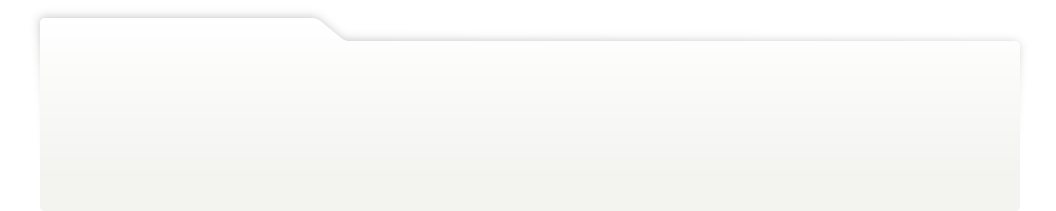
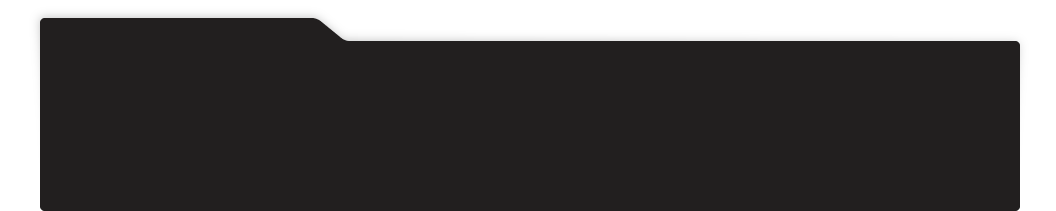
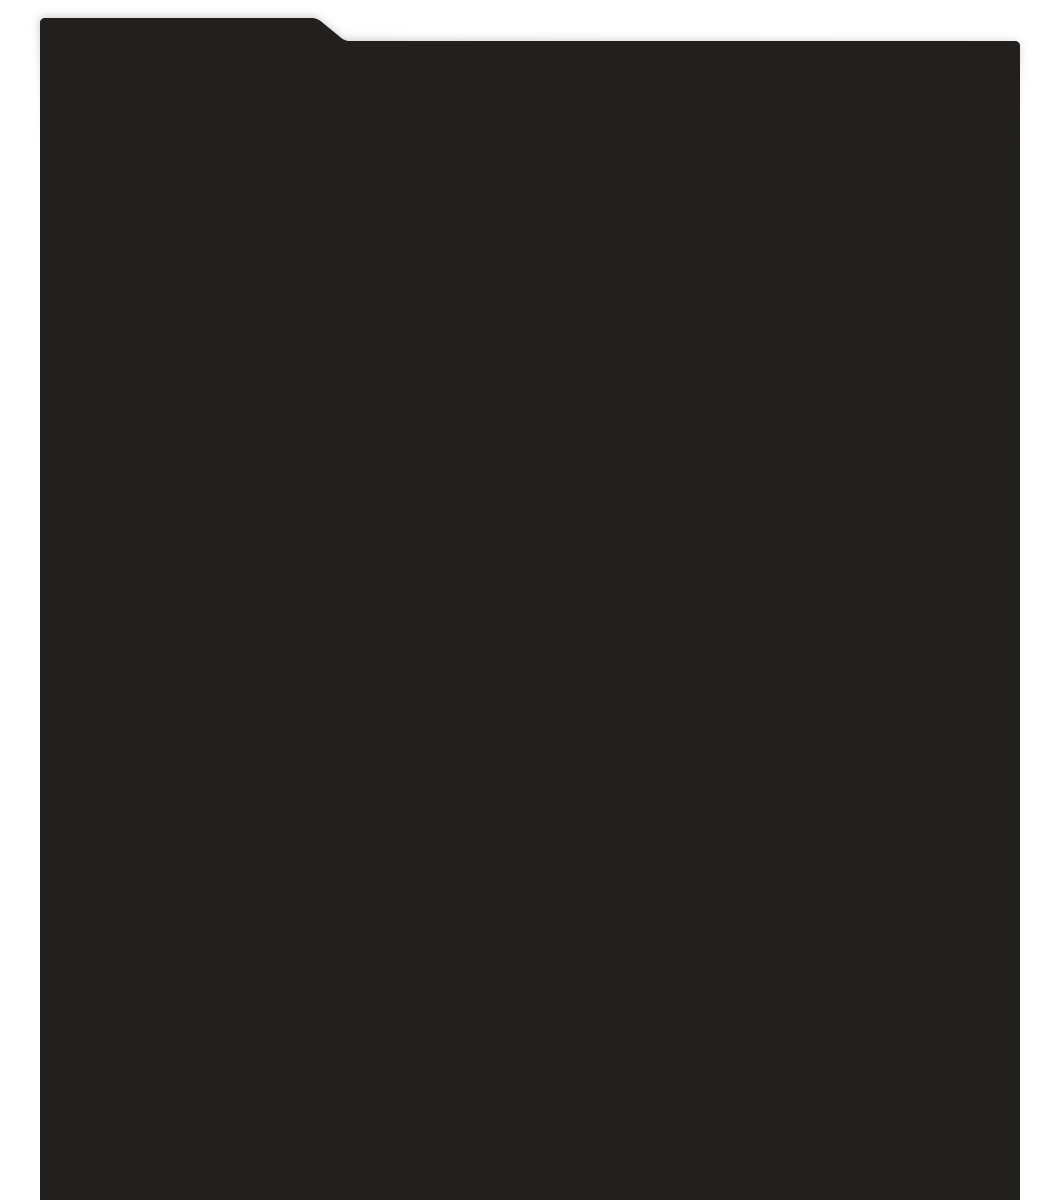
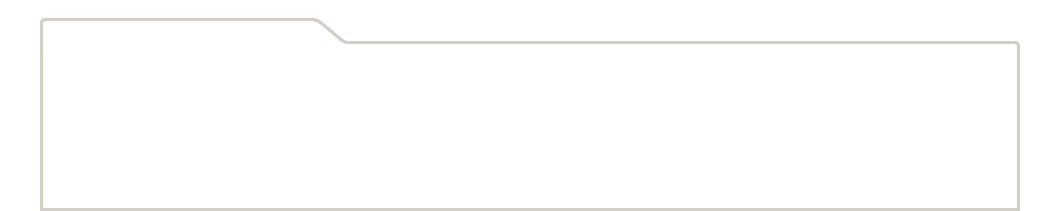
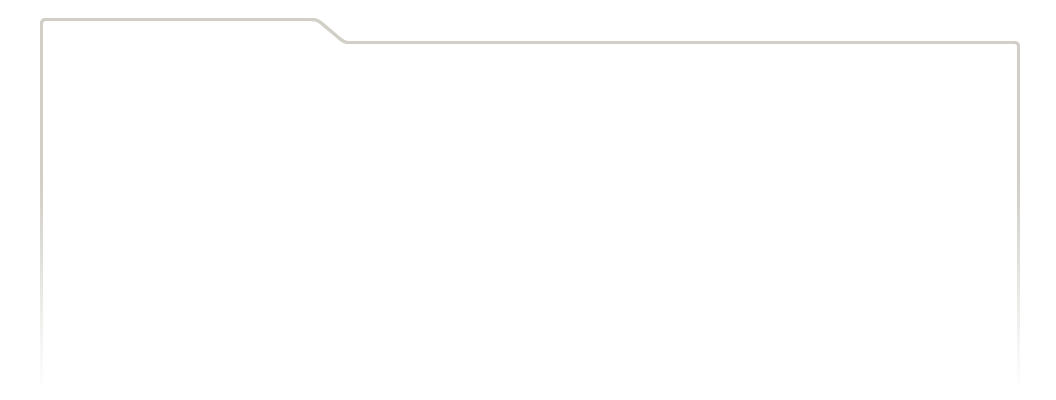
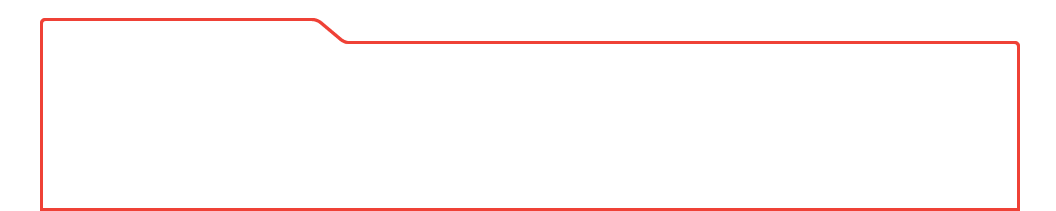
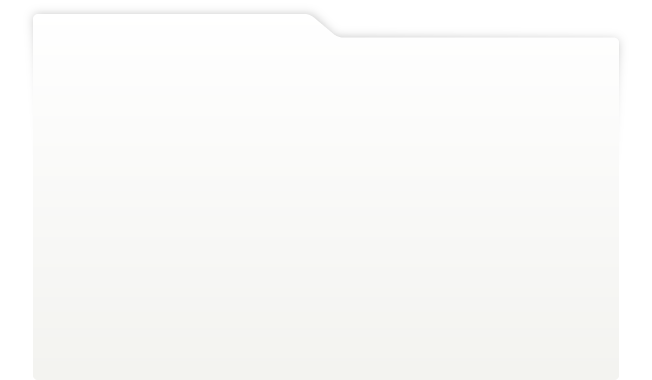
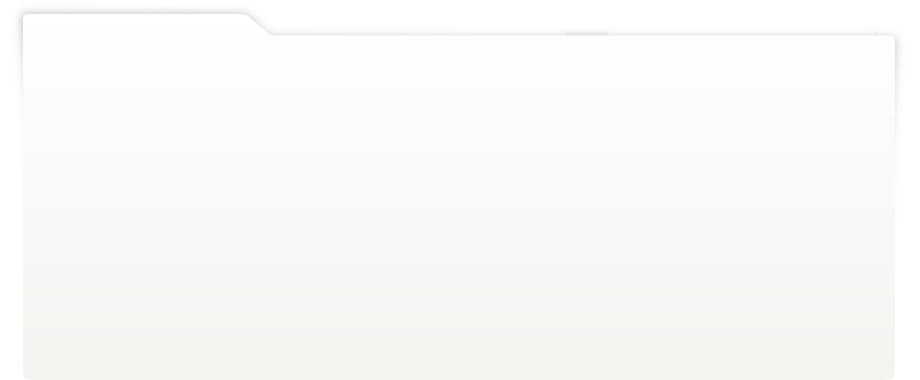
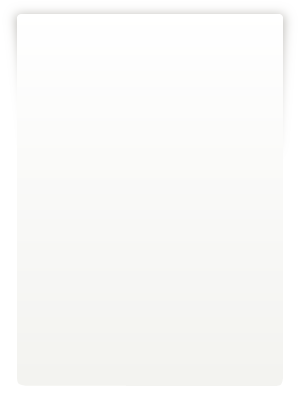
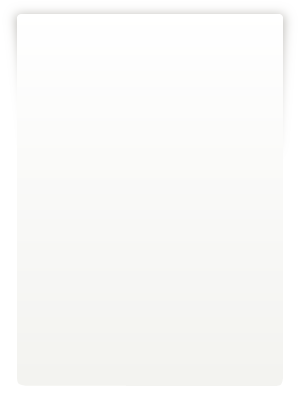
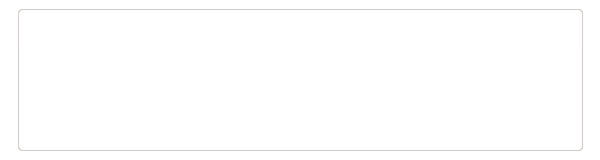
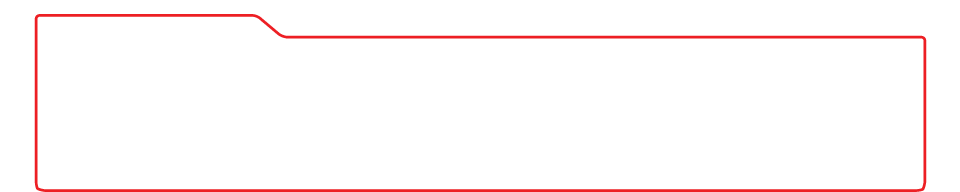
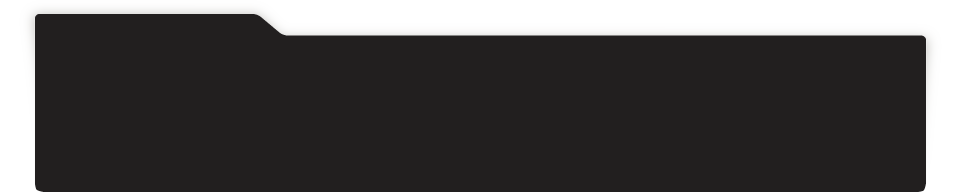
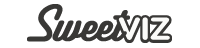
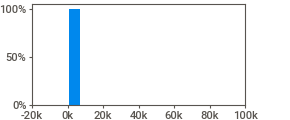
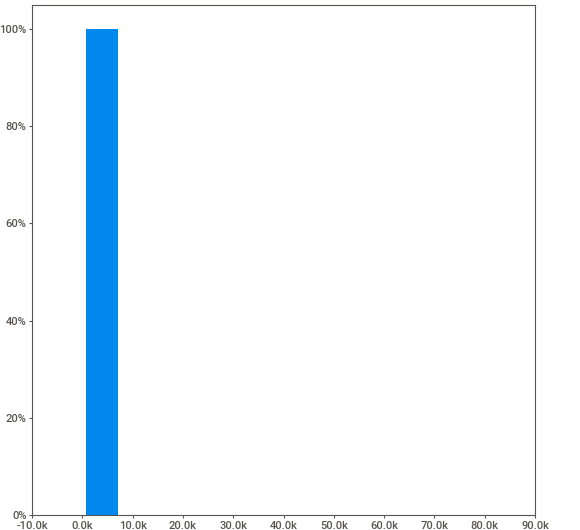
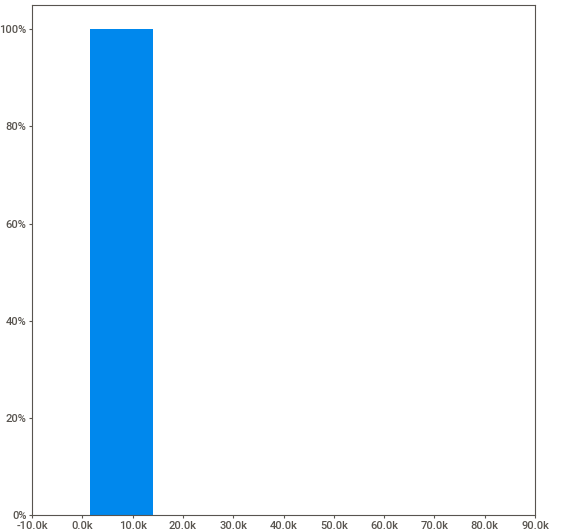
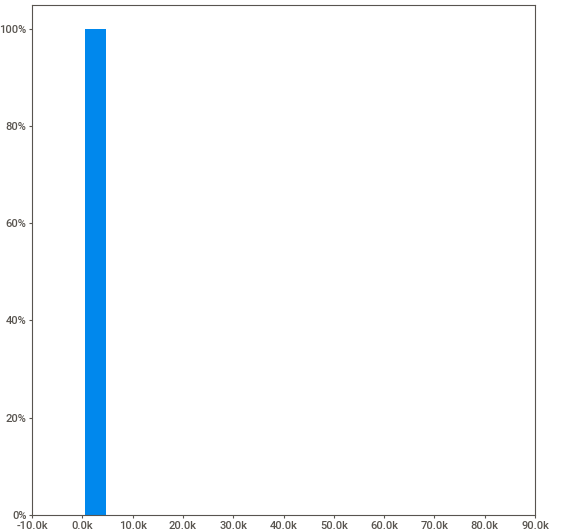
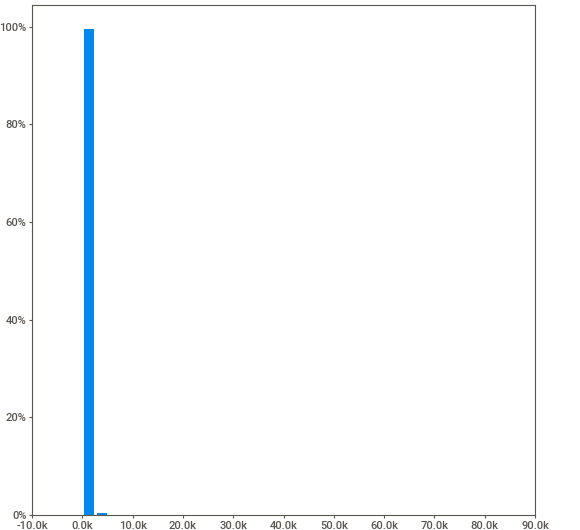
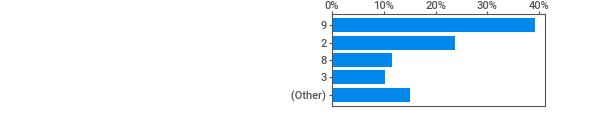
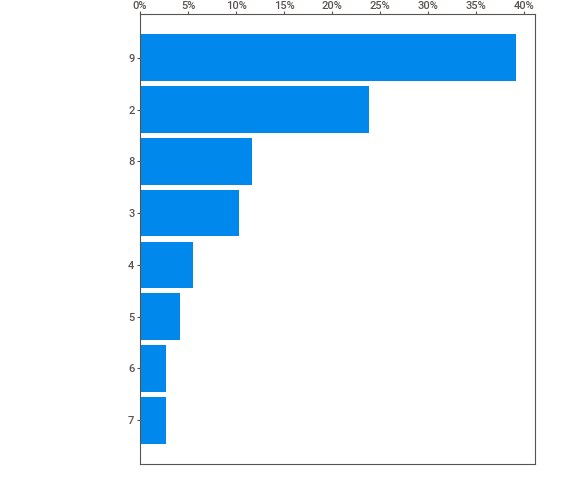
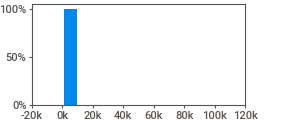
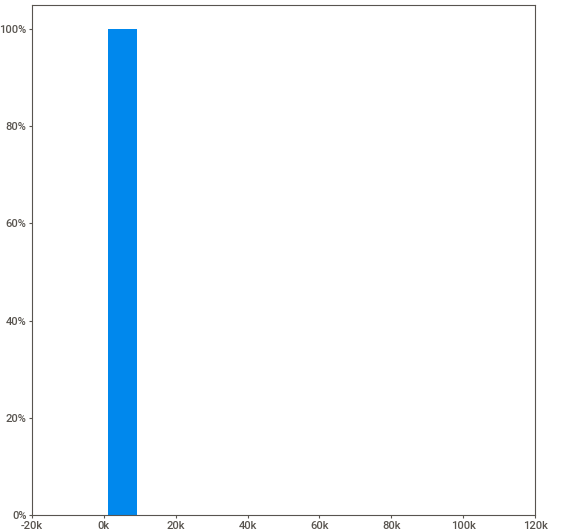
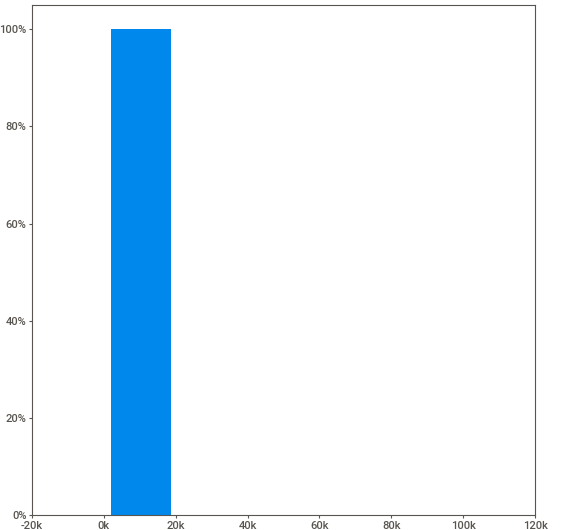
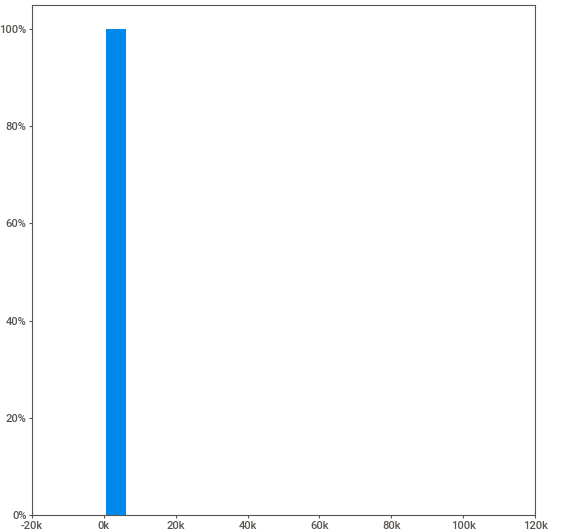
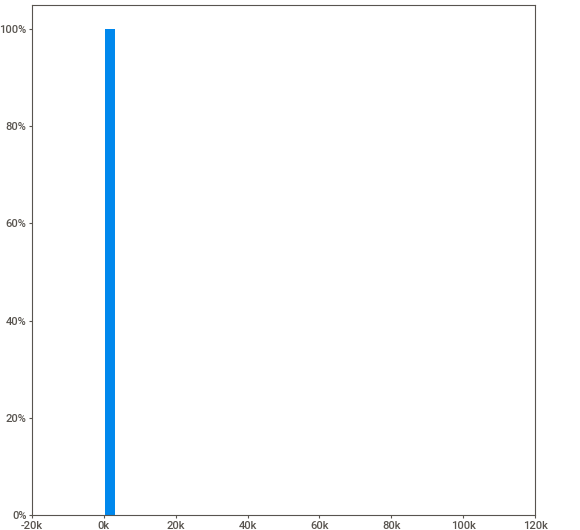
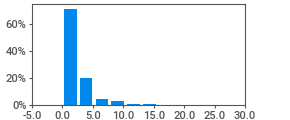
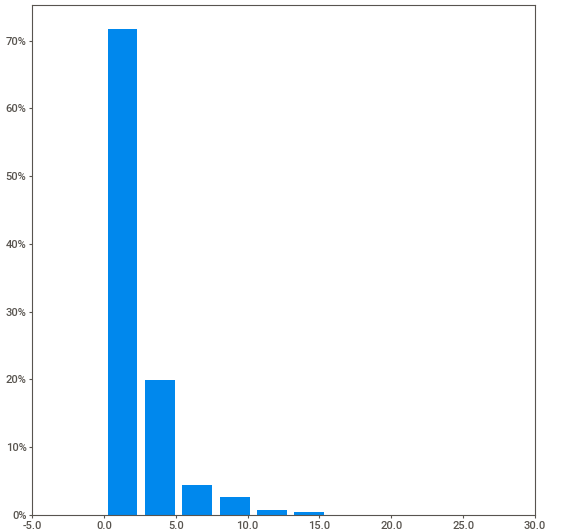
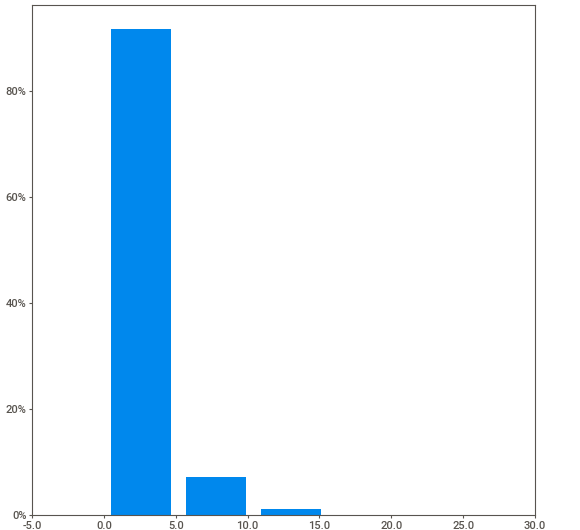
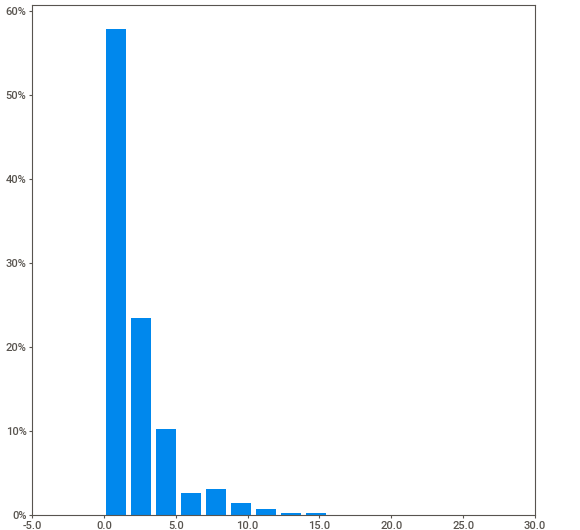
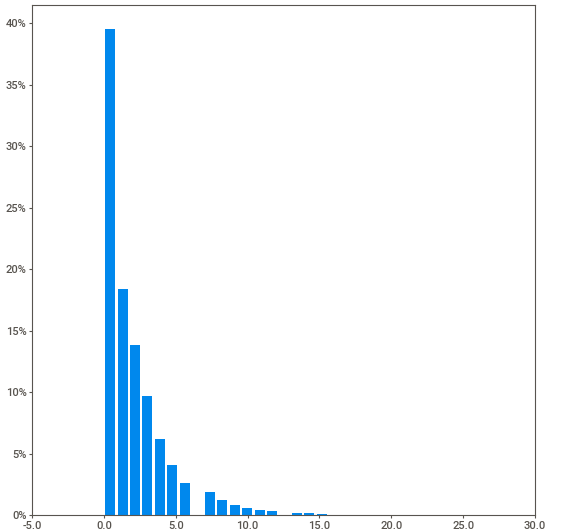
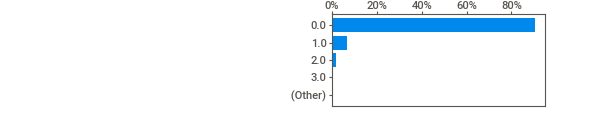
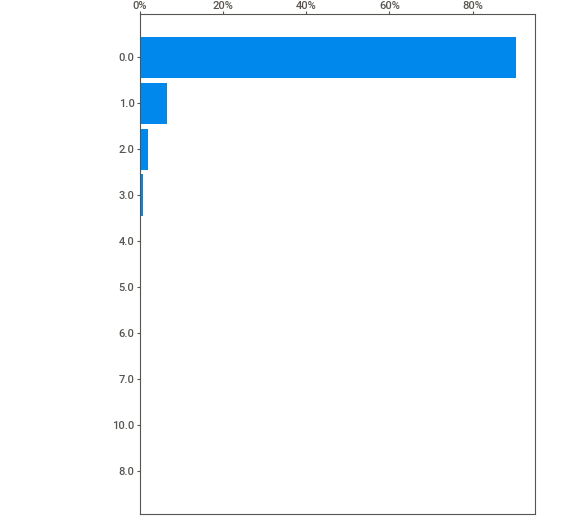
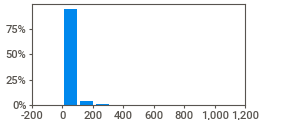
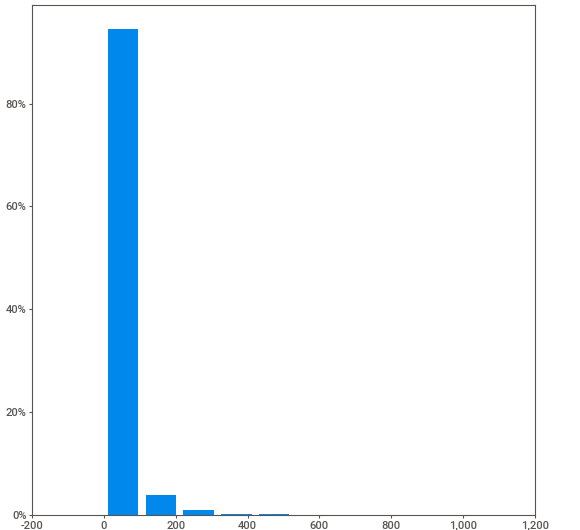
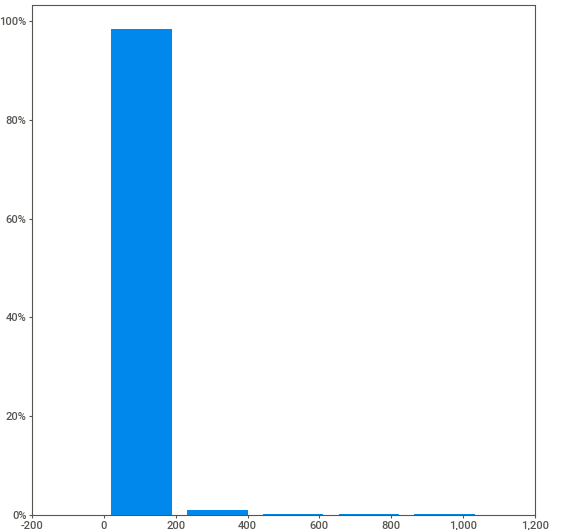
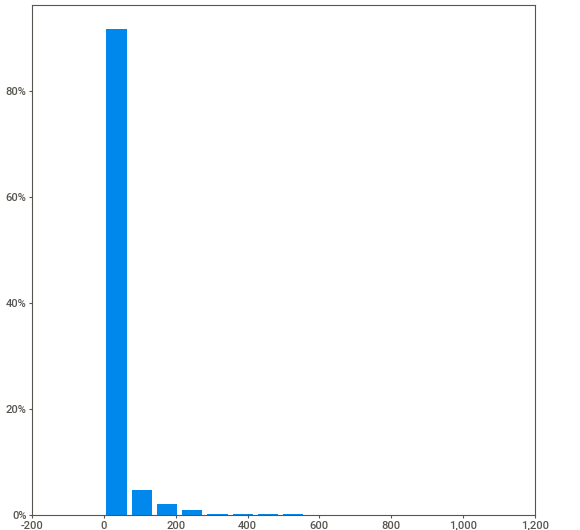
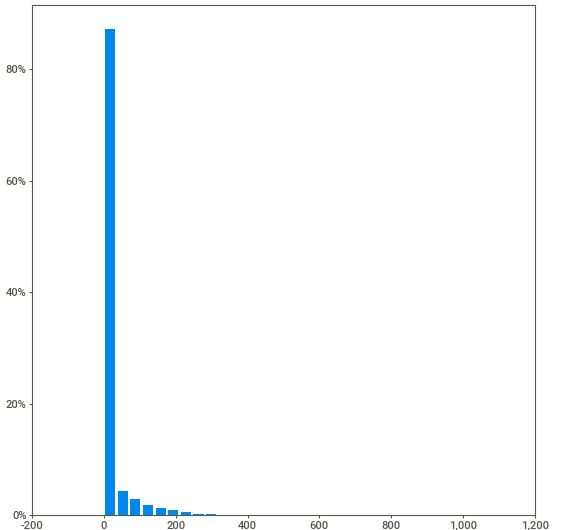
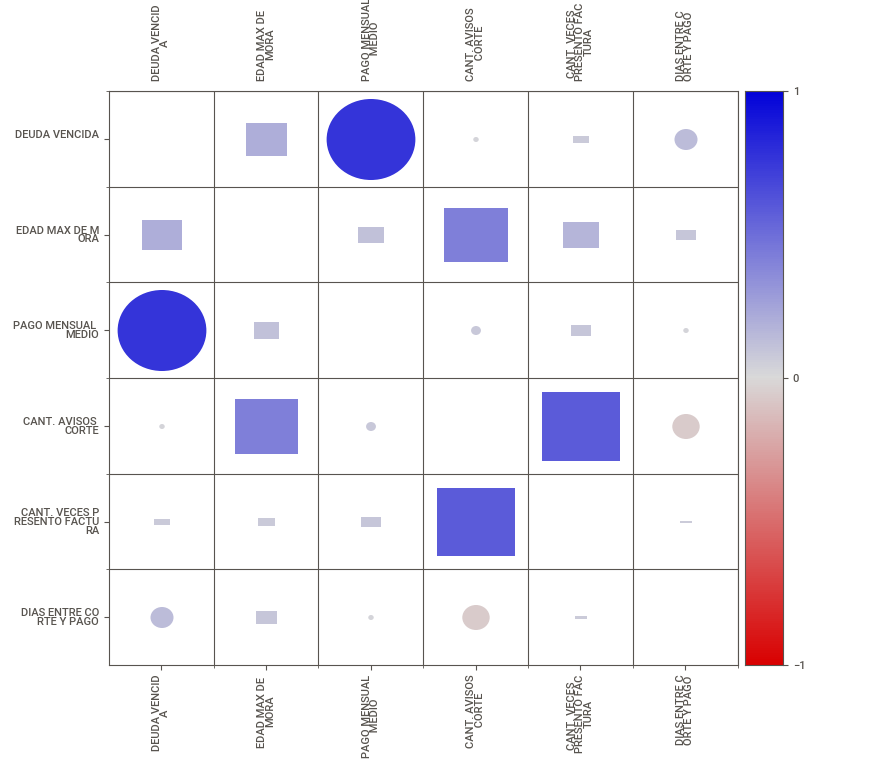
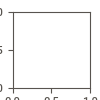

In [ ]:
sv.analyze(clientes_morosos).show_notebook()

## **Minería de datos**

En esta etapa aplicamos las diferentes técnicas (algoritmos), al dataset con las variables de interés, para la imputación de valores faltantes, detección de clientes anómalos y segmentación de clientes. 

### **Predicción de los días entre corte y pago**

Para los clientes que se ha efectuado uno o más cortes y reconexiones del suministro se espera que su pago después del corte sea el promedio de los días que han transcurridos entre la fecha de ejecución del corte y la fecha de solicitud de reconexión por deuda. Sin embargo, hay clientes que no cuentan con este dato así que hacemos inferencia (inputación) de estos a través de la técnica de K-Vecinos más cercanos.

In [ ]:
# Separamos a los clientes que tienen el dato para entrenar y validar el modelo
# y los datos para hacer las predicciones de los días que se espera que pague 
# déspues del corte.
# =============================================================================
datos_para_modelo = clientes_morosos[~clientes_morosos['DIAS ENTRE CORTE Y PAGO'].isnull()]
datos_para_predecir = clientes_morosos[clientes_morosos['DIAS ENTRE CORTE Y PAGO'].isnull()]

In [ ]:
X = datos_para_modelo.iloc[:,:-1].values 
y = datos_para_modelo.iloc[:,-1:].values

X = MinMaxScaler().fit_transform(X, y)

# Se divide el conjunto de datos en:
# 70% para entrenamito
# 30% para prueba
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=0,test_size=0.3)

# Se entrena el algoritmo.
# =============================================================================
# k_neighbors=KNeighborsRegressor(n_neighbors=20, weights='distance')
# reg=k_neighbors.fit(X_train, y_train)

# Algoritmo entrenado
# =============================================================================
reg = load('/content/drive/MyDrive/ENSA/Modelo de corte inteligente/Estimadores/dias_entre_corte_y_pago.joblib') 

print(f'MAE: {mean_absolute_error(y_test, reg.predict(X_test)):,.0f} DÍAS')

MAE: 26 DÍAS


In [ ]:
# Predicciones
# =============================================================================
X_predict = MinMaxScaler().fit_transform(datos_para_predecir.iloc[:,:-1].values) 
predict = reg.predict(X_predict)

In [ ]:
datos_para_predecir.loc[:, ['DIAS ENTRE CORTE Y PAGO']] = predict
datos_para_predecir.head()

,DEUDA VENCIDA,EDAD MAX DE MORA,PAGO MENSUAL MEDIO,CANT. AVISOS CORTE,CANT. VECES PRESENTO FACTURA,DIAS ENTRE CORTE Y PAGO
NÚMERO CUENTA CONTRATO,,,,,,
21120831,43.09,9,9.856667,0.0,0.0,80.008031
21120790,23.32,5,13.543750,0.0,0.0,4.226855
21097525,29.74,4,15.954286,1.0,0.0,3.346478
21090432,31.20,9,16.568571,0.0,0.0,79.091409
21085575,32.18,3,13.705312,0.0,0.0,8.954984


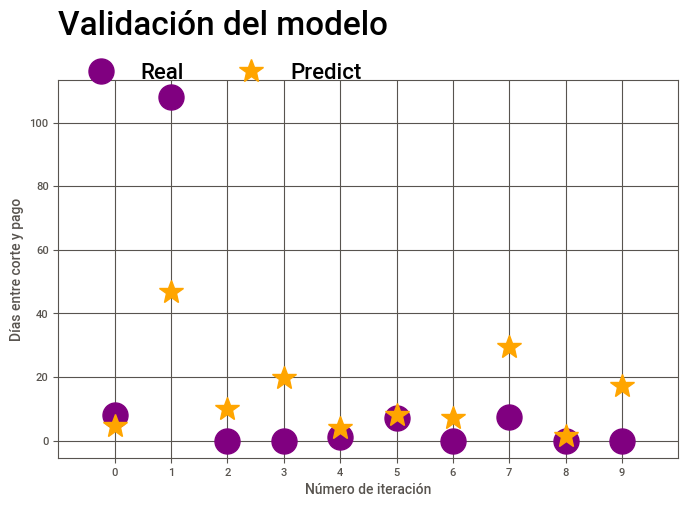

In [ ]:
# Gráficas
# =============================================================================
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(y_test[10:20],marker='o',lw=0,markersize=18,color='purple',label='Real')
ax.plot(reg.predict(X_test[10:20]),marker='*',lw=0,markersize=18,color='orange',
        label='Predict')
ax.legend(loc='upper left',ncol=2,fontsize=16,bbox_to_anchor=(0.0,0.0,0.0,1.1),
          frameon=False)
ax.grid()
ax.set_xticks(range(0, 10))
ax.set_xlim((-1, 10))
ax.set_xlabel('Número de iteración')
ax.set_ylabel('Días entre corte y pago')
ax.set_title('Validación del modelo\n',fontsize=24,loc='left',fontweight='bold')
fig.show()

In [ ]:
# Se unen los datos reales y con los datos inferidos
# =============================================================================
resultados = pd.concat([datos_para_modelo, datos_para_predecir])
resultados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38128 entries, 21120825 to 21247396
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DEUDA VENCIDA                 38128 non-null  float64
 1   EDAD MAX DE MORA              38128 non-null  int64  
 2   PAGO MENSUAL MEDIO            38128 non-null  float64
 3   CANT. AVISOS CORTE            38128 non-null  float64
 4   CANT. VECES PRESENTO FACTURA  38128 non-null  float64
 5   DIAS ENTRE CORTE Y PAGO       38128 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 2.0 MB


### **Detección de valores outliers**

Antes de crear los clústeres se crea una nueva variable "ES OUTLIER", a través de la técnica de Isolation Forest (Bosque Aislamiento), la cual devuelve 1 si es un cliente normal y -1 si es un cliente anómalo. El objetivo de esta variable es que cuando se creen los grupos o clúster con el algoritmo de agrupamiento los diferencie del resto y se creen grupos para estos clientes que deben tener un tratamiento especial. Para el entrenamiento de esta técnica utilizamos las variables 'DEUDA VENCIDA' y 'DIAS ENTRE CORTE Y PAGO' ya que en estas características están las anomalías que deseamos resaltar.


In [ ]:
# Se escalan los valores entre 0 y 1
# =============================================================================
X = MinMaxScaler().fit_transform(resultados[['DEUDA VENCIDA', 'DIAS ENTRE CORTE Y PAGO']].values)

# Entenamiento del algoritmo 
# =============================================================================
# isolation_forest=IsolationForest(n_estimators=100, max_samples=100, random_state=0, contamination='auto')

# Algoritmo entrenado
# =============================================================================
isolation_forest=load('/content/drive/MyDrive/ENSA/Modelo de corte inteligente/Estimadores/clientes_outliers.joblib') 

isOutlier=isolation_forest.fit_predict(X)
resultados['ES OUTLIER']=isOutlier
resultados.head()

,DEUDA VENCIDA,EDAD MAX DE MORA,PAGO MENSUAL MEDIO,CANT. AVISOS CORTE,CANT. VECES PRESENTO FACTURA,DIAS ENTRE CORTE Y PAGO,ES OUTLIER
NÚMERO CUENTA CONTRATO,,,,,,,
21120825,140.93,6,61.620000,4.0,0.0,6.0,1
21120830,114.89,4,103.106000,5.0,1.0,0.0,1
573864,23.74,2,37.158000,2.0,0.0,0.0,1
21213830,78.16,2,140.500000,3.0,0.0,0.0,1
21062132,33.46,3,61.242414,5.0,1.0,0.5,1


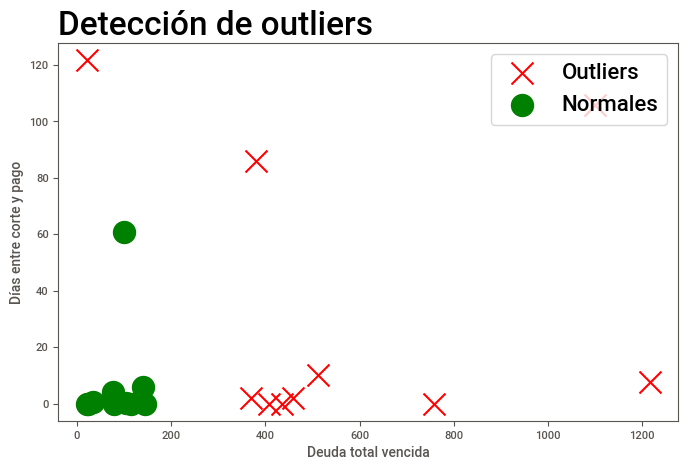

In [ ]:
# Gráficar
# =============================================================================
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(
    resultados.loc[resultados['ES OUTLIER']==-1,['DEUDA VENCIDA']][:10],
    resultados.loc[resultados['ES OUTLIER']==-1,['DIAS ENTRE CORTE Y PAGO']][:10],
    marker='x',
    c='red',
    s=250,
    label='Outliers'
)
ax.scatter(
    resultados.loc[resultados['ES OUTLIER']==1,['DEUDA VENCIDA']][:10],
    resultados.loc[resultados['ES OUTLIER']==1,['DIAS ENTRE CORTE Y PAGO']][:10],
    s=250,
    c='green',
    label='Normales'
)
ax.legend(loc='upper right',fontsize=16, frameon=True)
ax.set_title('Detección de outliers',fontsize=24,loc='left',fontweight='bold')
ax.set_xlabel('Deuda total vencida')
ax.set_ylabel('Días entre corte y pago')

fig.show()

### **Generación de clúster**

Se procede a crear los clústeres con el algoritmo de K-Medias. este algoritmo requiere se pasen el número de grupos que se desean crear. Se probaron varias combinaciones con diferentes números de clúster y mediante la experimentación concluimos que en el datasets hay 6 grupos distintos. Para la creación de los clústeres utilizamos las variables 'DEUDA VENCIDA', 'DIAS ENTRE CORTE Y PAGO', 'EDAD MAX DE MORA' ya que dado el contexto son las variables más importantes para la agrupación de clientes morosos. También se utilizó la variable 'ES OUTLIER' para que distinguiera a los clientes anómalos (con deuda muy alta y que demoran en pagar si los cortan) ya que estos deben tener otras estrategias de cobro.

In [ ]:
# Se escalan los valores entre 0 y 1
# =============================================================================
X_clustering = MinMaxScaler().fit_transform(resultados[['DEUDA VENCIDA', 'DIAS ENTRE CORTE Y PAGO', 'EDAD MAX DE MORA', 'ES OUTLIER']].values)

# Se entrena el algoritmo
# =============================================================================
# clustering=KMeans(n_clusters=6, random_state=0).fit(X_clustering)

# Algoritmo entrenado
# =============================================================================
clustering=load('/content/drive/MyDrive/ENSA/Modelo de corte inteligente/Estimadores/clustering.joblib') 
clusters =  clustering.predict(X_clustering)

In [ ]:
#
resultados_con_clusters = resultados

# Entrenamieto del algoritmo
# =============================================================================
# resultados_con_clusters['GRUPO'] = clustering.labels_

# Algoritmo entrenado
# =============================================================================
resultados_con_clusters['GRUPO'] = clusters

resultados_con_clusters.head()

,DEUDA VENCIDA,EDAD MAX DE MORA,PAGO MENSUAL MEDIO,CANT. AVISOS CORTE,CANT. VECES PRESENTO FACTURA,DIAS ENTRE CORTE Y PAGO,ES OUTLIER,GRUPO
NÚMERO CUENTA CONTRATO,,,,,,,,
21120825,140.93,6,61.620000,4.0,0.0,6.0,1,3
21120830,114.89,4,103.106000,5.0,1.0,0.0,1,3
573864,23.74,2,37.158000,2.0,0.0,0.0,1,0
21213830,78.16,2,140.500000,3.0,0.0,0.0,1,0
21062132,33.46,3,61.242414,5.0,1.0,0.5,1,0


## **Resultados**

El últmo paso antes de exportar los resultados, es la interpretación de estos.

In [ ]:
# Estadísticas descriptivas de los grupos
# =============================================================================
est_descr = resultados_con_clusters[['DEUDA VENCIDA','DIAS ENTRE CORTE Y PAGO','EDAD MAX DE MORA','GRUPO']]\
.groupby(['GRUPO']).describe().T

est_descr

GRUPO                                     0            1             2  \
DEUDA VENCIDA           count  12289.000000  9027.000000   6436.000000   
                        mean      56.838183   185.526848    687.750413   
                        std       53.249431   123.720141   1022.010658   
                        min       20.000000    20.000000     20.390000   
                        25%       26.110000    70.150000    294.982500   
                        50%       38.290000   179.500000    501.500000   
                        75%       64.630000   279.935000    767.142500   
                        max      473.710000   509.030000  53316.390000   
DIAS ENTRE CORTE Y PAGO count  12289.000000  9027.000000   6436.000000   
                        mean      13.418780    58.431328     74.564014   
                        std       21.153335    28.171046     62.434984   
                        min        0.000000     0.000000      0.000000   
                        25%        1.605740    40.743730     22.000000   
                        50%        5.000000    71.532426     85.598270   
                        75%       13.033687    79.323164    108.299541   
                        max       92.382281    94.166926    989.000000   
EDAD MAX DE MORA        count  12289.000000  9027.000000   6436.000000   
                        mean       2.307429     9.000000      8.885488   
                        std        0.461448     0.000000      0.433737   
                        min        2.000000     9.000000      6.000000   
                        25%        2.000000     9.000000      9.000000   
                        50%        2.000000     9.000000      9.000000   
                        75%        3.000000     9.000000      9.000000   
                        max        3.000000     9.000000      9.000000   

GRUPO                                    3             4            5  
DEUDA VENCIDA           count  4503.000000    866.000000  5007.000000  
                        mean     75.406125    941.052344   129.297120  
                        std      65.894946   4308.452438    85.874771  
                        min      20.000000     20.000000    20.020000  
                        25%      34.750000     28.422500    61.140000  
                        50%      54.280000    357.610000   110.800000  
                        75%      85.615000    724.025000   175.760000  
                        max     453.220000  78006.610000   476.680000  
DIAS ENTRE CORTE Y PAGO count  4503.000000    866.000000  5007.000000  
                        mean     14.354595     72.572438    12.421724  
                        std      14.575426    126.100992     7.764351  
                        min       0.000000      0.000000     0.000000  
                        25%       3.924171      3.563254    10.385910  
                        50%      11.254153     32.552108    12.468133  
                        75%      21.500000     93.370645    15.911561  
                        max      90.000000   1054.000000    85.000000  
EDAD MAX DE MORA        count  4503.000000    866.000000  5007.000000  
                        mean      4.761936      2.633949     7.810266  
                        std       0.783095      1.002287     0.392130  
                        min       4.000000      2.000000     7.000000  
                        25%       4.000000      2.000000     8.000000  
                        50%       5.000000      2.000000     8.000000  
                        75%       5.000000      3.000000     8.000000  
                        max       6.000000      5.000000     8.000000

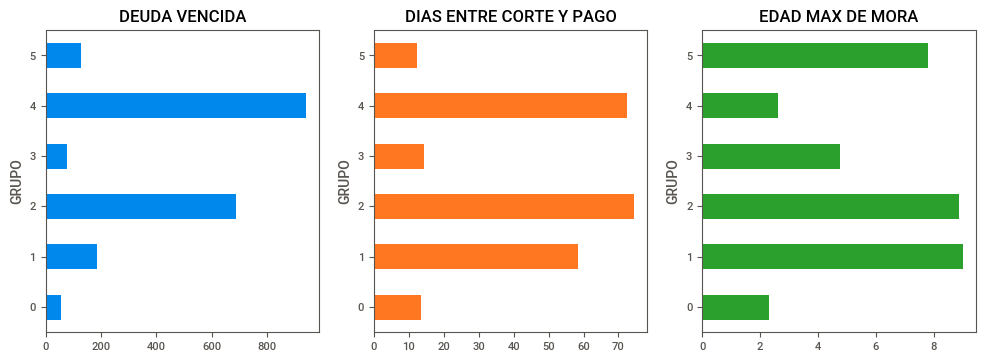

In [ ]:
# Gráfica de las principales variable para los clústeres.
# =============================================================================
resultados_con_clusters[['DEUDA VENCIDA','DIAS ENTRE CORTE Y PAGO','EDAD MAX DE MORA','GRUPO']]\
.groupby('GRUPO').mean()\
.plot.barh(subplots=True, figsize=(12,4),layout=(1, 3),legend=False, sharex=False)
plt.show()

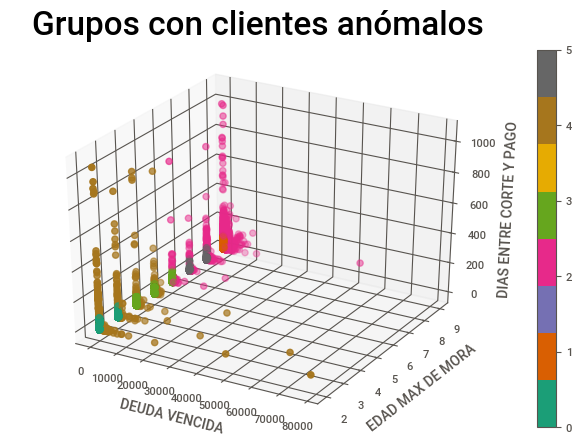

In [ ]:
# Gráicas 3D con la principales variables de los grupos. 
#==============================================================================
fig = plt.figure(figsize = (8, 5))
ax = plt.axes(projection ="3d")

p = ax.scatter3D(
    resultados_con_clusters.loc[:,['DEUDA VENCIDA']], 
    resultados_con_clusters.loc[:,['EDAD MAX DE MORA']], 
    resultados_con_clusters.loc[:,['DIAS ENTRE CORTE Y PAGO']], 
    c=resultados_con_clusters.loc[:,['GRUPO']],
    cmap=plt.cm.Dark2
)

plt.xlabel('DEUDA VENCIDA')
plt.ylabel('EDAD MAX DE MORA')
ax.set_zlabel('DIAS ENTRE CORTE Y PAGO')
fig.colorbar(p,  ticks=[0, 1, 2, 3, 4, 5])
plt.title('Grupos con clientes anómalos\n',fontsize=24,fontweight='bold')

plt.show()

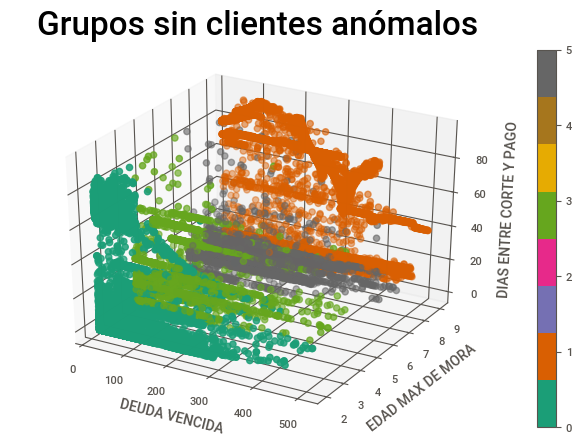

In [ ]:
# Gráicas 3D con la principales variables de los grupos. Sin clientes anómalos
#==============================================================================
filtro = resultados_con_clusters['ES OUTLIER'] != -1

fig = plt.figure(figsize = (8, 5))
ax = plt.axes(projection ="3d")

p = ax.scatter3D(
    resultados_con_clusters.loc[filtro,['DEUDA VENCIDA']], 
    resultados_con_clusters.loc[filtro,['EDAD MAX DE MORA']], 
    resultados_con_clusters.loc[filtro,['DIAS ENTRE CORTE Y PAGO']], 
    c=resultados_con_clusters.loc[filtro,['GRUPO']],
    cmap=plt.cm.Dark2
)

plt.xlabel('DEUDA VENCIDA')
plt.ylabel('EDAD MAX DE MORA')
ax.set_zlabel('DIAS ENTRE CORTE Y PAGO')
fig.colorbar(p,  ticks=[0, 1, 2, 3, 4, 5])
plt.title('Grupos sin clientes anómalos\n',fontsize=24,fontweight='bold')

plt.show()

### **Definición de los distintos perfiles de los clientes morosos**
Después de interpretar los resultados cambiamos los números de los grupos a nombres descriptivos de acuerdo con su perfil.

Fuente: [Segmentación de Deuda](https://aulicum.com/blog/segmentacion-de-deuda/)

Empezamos por los grupos que la técnica de Isolation Forest, clasifico como anómalos, estos grupos se caracterizan por una deuda vencida alta y que demoran en pagar si le cortan el suministro eléctrico, se diferencian entre ellos por la edad de mora.

-	Deudor Negligente (Grupo 2): Mayor Edad de mora alta de 180 a más de 365 días.
-	Deudor intencional (Grupo 4): Su edad de mora es de 60 a 150 días. Si no se toman medidas se convertirá en un negligente.

Ahora seguimos con los clústeres que tienen un comportamiento más normalizado. La principal distinción de estos grupos es la edad de mora.

-	Deudor ocasional (Grupo 0): Tiene una edad de mora fresca de 60 a 90 días.
-	Deudor recurrente (Grupo 1): Tiene una edad de mora de alta mayor a 365 días.

Por último, los dos grupos que se encuentran en el medio
-	Mora media-temprana (Grupo 3): Tiene una edad de mora de 120 a 180 días.
-	Mora media-tardía (GRUPO 5): Tiene una edad de mora de 210 a 365 días




In [ ]:
# Se crea una variable de tipo object que contenga una el perfil de cada grupo
# =============================================================================
perfiles = {
    'GRUPO':[0, 1, 2, 3, 4, 5], 
    'PERFIL':['Deudor ocasional',   # 0 
              'Deudor recurrente',  # 1
              'Deudor Negligente',  # 2
              'Mora media-temprana',# 3
              'Deudor Intencional', # 4
              'Mora media-tardía']  # 5
    }

perfiles = pd.DataFrame(perfiles)

## **Exportar resultados**

Por último, se procede con la exportación de los resultados. Esta exportación alimenta de forma directa la fuente de datos de un dashboard hecho en la herramienta Looker Data Studio. Pero antes de ejecutar la exportación añadimos más información descriptiva al data frame.

In [ ]:
# Se agrega la variable PERFIL a data frame
# =============================================================================
resultados_con_clusters.reset_index(inplace=True)
resultados_con_clusters = pd.merge(resultados_con_clusters, perfiles,how='left',on='GRUPO') 

In [ ]:
# Se añade la recomendación para cada grupo
# =============================================================================
acciones = {
    0:'NO CORTAR', 
    1:'CORTAR PRIORIDAD 3',
    2:'REGLAS DE COBRO',
    3:'CORTAR PRIORIDAD 2',
    4:'REGLAS DE COBRO',
    5:'CORTAR PRIORIDAD 1',
}

# Se agrega la acción o recomendación
# =============================================================================
resultados_con_clusters.loc[resultados_con_clusters['GRUPO']==0,['RECOMENDACIÓN']]=acciones[0]
resultados_con_clusters.loc[resultados_con_clusters['GRUPO']==1,['RECOMENDACIÓN']]=acciones[1]
resultados_con_clusters.loc[resultados_con_clusters['GRUPO']==2,['RECOMENDACIÓN']]=acciones[2]
resultados_con_clusters.loc[resultados_con_clusters['GRUPO']==3,['RECOMENDACIÓN']]=acciones[3]
resultados_con_clusters.loc[resultados_con_clusters['GRUPO']==4,['RECOMENDACIÓN']]=acciones[4]
resultados_con_clusters.loc[resultados_con_clusters['GRUPO']==5,['RECOMENDACIÓN']]=acciones[5]

Dado que la capacidad de corte tiene un tope de 10 mil clientes, validamos este número y si la cantidad de clientes recomendados para corte supera este límite los retiramos de los clientes a cortar prioridad 3 (quitamos los que demoran más en pagar) para asignarles otras reglas de cobro.

In [ ]:
# Total de clientes a cortar prioridad 1 y 2
# =============================================================================
cant_clientes_cortar = resultados_con_clusters[
    (resultados_con_clusters['RECOMENDACIÓN'] == 'CORTAR PRIORIDAD 1') | 
    (resultados_con_clusters['RECOMENDACIÓN'] == 'CORTAR PRIORIDAD 2') |
    (resultados_con_clusters['RECOMENDACIÓN'] == 'CORTAR PRIORIDAD 3')
    ].count()[0]
print(f"Total de clientes a cortar prioridad 1, 2 y 3: {cant_clientes_cortar:,}")

# Ordenar el data frame por valores
# =============================================================================
resultados_con_clusters.sort_values(by = 'DIAS ENTRE CORTE Y PAGO', inplace = True, ascending = False)

# Excedente de cortes
# =============================================================================
if cant_clientes_cortar > 10_000:
    excedente_cortes = cant_clientes_cortar - 10_000 
    print(f"Total de excedente en cortes: {excedente_cortes:,}")
    sub_grupo = cant_clientes_cortar = resultados_con_clusters[
        (resultados_con_clusters['RECOMENDACIÓN'] == 'CORTAR PRIORIDAD 3')
    ]
    
    sub_grupo.iloc[:excedente_cortes, 10] = 'REGLAS DE COBRO'

    # Actualizar el Data frame
    resultados_con_clusters.update(sub_grupo)

# Ordenar el data frame por index
# =============================================================================
resultados_con_clusters.sort_index(inplace = True)

Total de clientes a cortar prioridad 1, 2 y 3: 18,537
Total de excedente en cortes: 8,537


In [ ]:
# Parseamos la varialbe EDAD MAX DE MORA de número a texto
# =============================================================================
resultados_con_clusters.loc[resultados_con_clusters['EDAD MAX DE MORA']==2,['EDAD MAX DE MORA']]='DEUDA 60 DIAS'
resultados_con_clusters.loc[resultados_con_clusters['EDAD MAX DE MORA']==3,['EDAD MAX DE MORA']]='DEUDA 90 DIAS'
resultados_con_clusters.loc[resultados_con_clusters['EDAD MAX DE MORA']==4,['EDAD MAX DE MORA']]='DEUDA 120 DIAS'
resultados_con_clusters.loc[resultados_con_clusters['EDAD MAX DE MORA']==5,['EDAD MAX DE MORA']]='DEUDA 150 DIAS'
resultados_con_clusters.loc[resultados_con_clusters['EDAD MAX DE MORA']==6,['EDAD MAX DE MORA']]='DEUDA 180 DIAS'
resultados_con_clusters.loc[resultados_con_clusters['EDAD MAX DE MORA']==7,['EDAD MAX DE MORA']]='DEUDA 210 DIAS'
resultados_con_clusters.loc[resultados_con_clusters['EDAD MAX DE MORA']==8,['EDAD MAX DE MORA']]='DEUDA 365 DIAS'
resultados_con_clusters.loc[resultados_con_clusters['EDAD MAX DE MORA']==9,['EDAD MAX DE MORA']]='DEUDA > 365 DIAS'

In [ ]:
# Se añade la fecha y monto del último pago para cada cuenta
# =============================================================================
resultados_con_otros_datos = pd.merge(
    resultados_con_clusters, 
    dataset[['NÚMERO CUENTA CONTRATO','MONTO ÚLTIMO PAGO','FECHA ÚLTIMO PAGO']],
    on='NÚMERO CUENTA CONTRATO',how='left')

# Tomamos más datos del extractor de morosidad
# =============================================================================
otros_datos = morosidad[['Número cuenta contrato', 
                         'Categoría cuenta contrato', 
                         'Clase interlocutor comercial', 
                         'Provincia', 'Distrito' , 
                         'Corregimiento', 
                         'Barrio' ]]

# Cambiamos el nombre de las columnas (variables) a mayúscula cerrada.
#==============================================================================
otros_datos.columns = otros_datos.columns.str.upper()

# Unimos el data frame de los resultados con otros datos.
# =============================================================================
resultados_con_otros_datos=pd.merge(resultados_con_otros_datos,
                                    otros_datos,
                                    on='NÚMERO CUENTA CONTRATO',
                                    how='left')
resultados_con_otros_datos.head()

,NÚMERO CUENTA CONTRATO,DEUDA VENCIDA,EDAD MAX DE MORA,PAGO MENSUAL MEDIO,CANT. AVISOS CORTE,CANT. VECES PRESENTO FACTURA,DIAS ENTRE CORTE Y PAGO,ES OUTLIER,GRUPO,PERFIL,RECOMENDACIÓN,MONTO ÚLTIMO PAGO,FECHA ÚLTIMO PAGO,CATEGORÍA CUENTA CONTRATO,CLASE INTERLOCUTOR COMERCIAL,PROVINCIA,DISTRITO,CORREGIMIENTO,BARRIO
0,21120825.0,140.93,DEUDA 180 DIAS,61.620000,4.0,0.0,6.0,1.0,3.0,Mora media-temprana,CORTAR PRIORIDAD 2,154.12,2022-06-21,Residencial,Normales,PANAMA,PANAMA,ERNESTO CORDOBA CAMPOS,TIERRA PROMETIDA
1,21120830.0,114.89,DEUDA 120 DIAS,103.106000,5.0,1.0,0.0,1.0,3.0,Mora media-temprana,CORTAR PRIORIDAD 2,60.00,2022-09-20,Residencial,Normales,PANAMA,PANAMA,ERNESTO CORDOBA CAMPOS,TIERRA PROMETIDA
2,573864.0,23.74,DEUDA 60 DIAS,37.158000,2.0,0.0,0.0,1.0,0.0,Deudor ocasional,NO CORTAR,41.81,2022-08-22,Residencial,Normales,PANAMA,PANAMA,LAS MAÑANITAS,RESID. LAS AMERICAS
3,21213830.0,78.16,DEUDA 60 DIAS,140.500000,3.0,0.0,0.0,1.0,0.0,Deudor ocasional,NO CORTAR,150.00,2022-10-06,Residencial,Normales,COLON,COLON,SAN JUAN,BDA. JUAN DEMOSTENES AROSEME
4,21062132.0,33.46,DEUDA 90 DIAS,61.242414,5.0,1.0,0.5,1.0,0.0,Deudor ocasional,NO CORTAR,80.00,2022-10-14,Residencial,Normales,COLON,COLON,SABANITAS,SANTA RITA


In [ ]:
# Se obtiene la hoja de cálculo donde se almacenan los resultados y se limpia.
# =============================================================================
sheet_resultados = '/content/drive/MyDrive/ENSA/Modelo de corte inteligente/Resultados2.0/Resultados2.0.gsheet'
id_resultados = get_id(sheet_resultados)
worksheet = gc.open_by_key(id_resultados).sheet1
worksheet.clear()

{'spreadsheetId': '1LPPb--xXcSQVpmi50fTPPeehGPmloY4Z6qJb5Zt1DoY',
 'clearedRange': 'Sheet1!A1:S51029'}

In [ ]:
# Reemplazamos valores nan por 0 para que se actulize la base de datos con los resultado
# =============================================================================
resultados_con_otros_datos.fillna(0, inplace=True)

# Parseamos las fechas para no tener errores.
# =============================================================================
resultados_con_otros_datos['FECHA ÚLTIMO PAGO'] = resultados_con_otros_datos['FECHA ÚLTIMO PAGO'].astype('str')

In [ ]:
# Se actualiza la hoja con los nuevos resultados.
# =============================================================================
worksheet.update([resultados_con_otros_datos.columns.values.tolist()]+
                 resultados_con_otros_datos.values.tolist())

{'spreadsheetId': '1LPPb--xXcSQVpmi50fTPPeehGPmloY4Z6qJb5Zt1DoY',
 'updatedRange': 'Sheet1!A1:S38129',
 'updatedRows': 38129,
 'updatedColumns': 19,
 'updatedCells': 724451}

## **Persistencia del modelo**

Exportamos las técnicas de Machine Learning ya entrenadas para no tener que reentrenar los algoritmos y sobre todo no tener de redefinir a los grupos o clústeres nuevamente.

In [ ]:
# Exportar los modelos
# ============================================================================
# from joblib import dump
# dump(k_neighbors,'dias_entre_corte_y_pago.joblib') 
# dump(isolation_forest,'/content/drive/MyDrive/ENSA/Modelo de corte inteligente/Estimadores/clientes_outliers.joblib') 
# dump(clustering,'/content/drive/MyDrive/ENSA/Modelo de corte inteligente/Estimadores/clustering.joblib') 

## [Ir al dashboard](https://datastudio.google.com/reporting/a2b0c26d-dda6-46b4-a519-a92ff7bc511a)


In [ ]:
# !jupyter nbconvert --to html Modelo_de_Segmentación_y_Recomendación.ipynb

[NbConvertApp] Converting notebook Modelo_de_Segmentación_y_Recomendación.ipynb to html
[NbConvertApp] Writing 1872255 bytes to Modelo_de_Segmentación_y_Recomendación.html
